In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import numpy as np
import seaborn as sns
import torch

import sys
BASE_PATH = globals()['_dh'][0].parent.absolute()
sys.path.insert(1, str(BASE_PATH))

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from src.utils.utils import make_Planetoid_data, exp_per_model, make_uniform_schedule, make_Amazon_data, count_parameters
from src.utils.metrics import MAD
from src.models.models import GCN, GAT
from src.models.iterativeModels import iterativeGAT
import torch.nn.functional as F
wandb.login()

True

In [ ]:
hyper = {
    'num_epochs': 200,
    'dataset_name': "Computers",
    'noise_percent': 0,
    'hid_dim': 32,
    'num_iter_layers': 6,
    'smooth_fac': 0.8,
    'dropout': 0.5,
    'learning_rate': 0.01,
    'weight_decay': 4e-4
} 
# data, num_features, num_classes = make_Planetoid_data(hyper)

In [ ]:
from torch_geometric.datasets import Amazon, Planetoid
dataset = Amazon(root='data/Amazon',
                     name='Computers',
                     transform=NormalizeFeatures())
dataset2 = Planetoid(root='data/Planetoid/',
                     name='Cora',
                     transform=NormalizeFeatures())


In [ ]:
from torch_geometric.utils import contains_self_loops, add_remaining_self_loops

In [ ]:
data = dataset2[0]
data.edge_index

In [ ]:
data.edge_index = add_remaining_self_loops(data.edge_index)[0]

In [ ]:
data.edge_index

In [ ]:
contains_self_loops(data.edge_index)

In [ ]:
data = dataset[0]
train_nodes = []
valid_nodes = []
test_nodes = []
for i in torch.unique(data.y).tolist():
    print((data.y == i).nonzero(as_tuple=True)[0][0:20])
    


In [ ]:
(data.y == 0).nonzero(as_tuple=True)[0][0:10]

In [ ]:
wandb.init(config=hyper, job_type="debug", project="IterativeMethods", tags=["GAT"])
config = wandb.config
train_schedule = make_uniform_schedule(config.num_iter_layers, config.smooth_fac)
data, num_features, num_classes = make_Amazon_data(config)
wandb.log({
    'train_schedule': train_schedule
})
model = GAT(num_node_features=num_features,
            output_dim=num_classes,
            hidden_dim=8,
            num_layers=config.num_iter_layers,
            attn_dropout_rate=0.6,
            dropout=0.6
)
exp_per_model(model, data, config)
wandb.finish()

In [ ]:
wandb.init(config=hyper, job_type="debug", project="IterativeMethods", tags=["GAT"])
config = wandb.config
train_schedule = make_uniform_schedule(config.num_iter_layers, config.smooth_fac)
data, num_features, num_classes = make_Amazon_data(config)
wandb.log({
    'train_schedule': train_schedule
})
model = iterativeGAT(input_dim=num_features,
                     output_dim=num_classes,
                     hidden_dim=config.hid_dim,
                     train_schedule=train_schedule,
                     heads=8,
                     dropout=0.6,
                     attn_dropout_rate=0.6)
exp_per_model(model, data, config)
wandb.finish()

In [ ]:
wandb.init(config=hyper, 
               job_type="iterativeGAT", 
               project="IterativeMethods", 
               tags=["iterativeGCN"])
config = wandb.config
train_schedule = make_uniform_schedule(config.num_iter_layers, config.smooth_fac)
data, num_features, num_classes = make_Planetoid_data(config)
wandb.log({
    'train_schedule': train_schedule
})

model = iterativeGCN(input_dim=num_features,
                                output_dim=num_classes,
                                hidden_dim=config.hid_dim,
                                train_schedule=train_schedule,
                                dropout=config.dropout)
exp_per_model(model, data, config)

out = model(data.x, data.edge_index)
mad1 = MAD(out.detach())
mad2  =MAD(F.log_softmax(out, dim=1))
mad3 = MAD(F.softmax(out, dim=1))
// print(mad1)
// print(mad2)
print(mad3)

wandb.finish()

In [ ]:
wandb.init(job_type="over_smoothing", 
               project="IterativeMethods", 
               config=hyper, 
               notes="usualGCN",
               tags=["usualGCN"])
config = wandb.config
model2 = GCN(input_dim=num_features,
                                output_dim=num_classes,
                                hidden_dim=config.hid_dim,
                                num_layers=config.num_iter_layers,
                                dropout=config.dropout,
                                )
exp_per_model(model2, data, config)
out2 = model2(data.x, data.edge_index)

mad1 = MAD(out2.detach())
mad2 = MAD(F.log_softmax(out2, dim=1))
mad3 = MAD(F.softmax(out2, dim=1))

# print(mad1)
# print(mad2)
print(mad3)

wandb.finish()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
torch.set_printoptions(profile="full", sci_mode=False, precision=4)
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
out2 = model2(data.x, data.edge_index)
D = 1 - cosine_similarity(out2.detach())
print(D)

# other

In [ ]:
iMAD = [0.7474, 0.7881, 0.8062, 0.8044, 0.8058, 0.8207, 0.8070, 0.7913, 0.8005, 0.8042, 0.8061, 0.7774, 0.7152, 0.7403, 0.8081, 0.7029, 0.7716, 0.7167, 0.7368]
uMAD = [0.6512, 0.7687, 0.8147, 0.8125, 0.8088, 0.7588, 0.6406, 0.5322, 0.0153, 0.0537, 0.0821, 0.1540, 0.0249, 0.0858, 0.0728, 0.1526, 0.0537, 0.0227, 0.0252]
x = np.arange(2, 21,1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, iMAD)
plt.plot(x, uMAD)
plt.ylabel('MAD')
plt.xlabel('number of iteration/layer')
xi = list(range(len(x)))
plt.xticks(xi, x)

In [5]:
model = GAT(
    num_node_features=1433,
    hidden_dim=8,
    output_dim=7,
    num_layers=2,
    attn_dropout_rate=0.6,
    dropout=0.6,
    heads=8
)
count_parameters(model)
# print(model)
# for p in model.parameters():
#      if p.requires_grad:
#         #   print(p)
#           print(p.size())


92302

In [4]:
imodel = iterativeGAT(input_dim=1433,
                     output_dim=7,
                     hidden_dim=32,
                     train_schedule=[0.5, 0.5, 0.5],
                     heads=8)
count_parameters(imodel)

55079

In [6]:
import torch
torch.device('cuda')

AttributeError: 'torch.device' object has no attribute 'item'

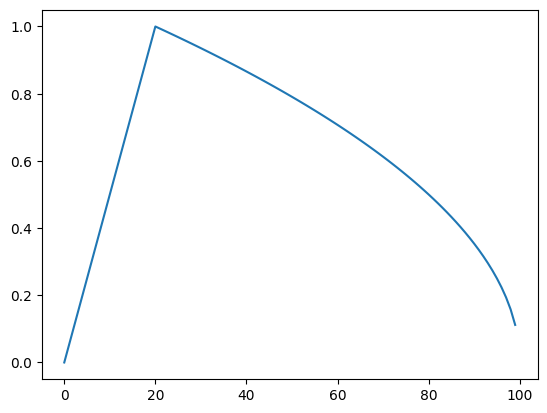

In [9]:
import matplotlib.pyplot as plt
from math import sqrt

def lr_warmup(current_step: int,
              warmup_steps: int,
              training_steps: int):
    if current_step < warmup_steps:  # current_step / warmup_steps * base_lr
        return float(current_step / warmup_steps)
    else:                                 # (num_training_steps - current_step) / (num_training_steps - warmup_steps) * base_lr
        return max(0.0, sqrt(float(training_steps - current_step) / float(max(1, training_steps - warmup_steps))))

train_steps = 100
warmup_steps = 20

a = []

for i in range(train_steps):
    a.append(lr_warmup(i, warmup_steps, train_steps))
plt.plot(a)

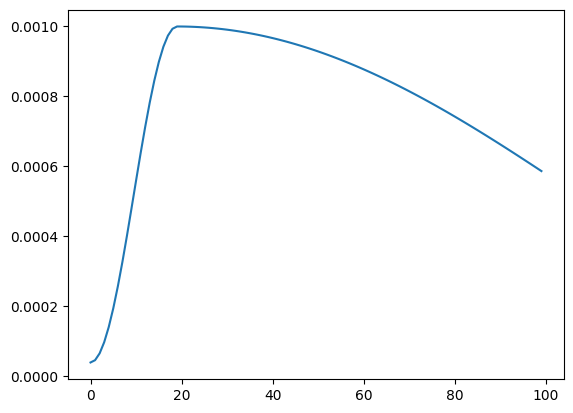

In [23]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam
imodel = iterativeGAT(input_dim=1433,
                     output_dim=7,
                     hidden_dim=32,
                     train_schedule=[0.5, 0.5, 0.5],
                     heads=8)
optimizer = Adam(imodel.parameters(), lr=0.01)
lr = OneCycleLR(optimizer, max_lr=0.001, epochs=100, steps_per_epoch=2, pct_start=0.1)
lrs=[]
for epoch in range(100):
    optimizer.step()
    lrs.append(lr.get_last_lr()[0])
    lr.step()

import matplotlib.pyplot as plt
plt.plot(lrs)

In [22]:
lr.get_last_lr()[0]

0.0005782189196511853

In [3]:
import torch.nn as nn
import torch
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
print(output.item())

1.1822155714035034
